In [25]:
import pandas as pd
import yfinance as yf
import numpy as np
from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [26]:
# Define the ticker symbol
tickerSymbol = 'QQQ'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2010-1-1', end='2023-11-04')
tickerDf['Date'] = tickerDf.index.date

# See your data
print(tickerDf)

                                 Open        High         Low       Close  \
Date                                                                        
2010-01-04 00:00:00-05:00   23.271758   23.636566   23.248957   23.522564   
2010-01-05 00:00:00-05:00   23.446566   23.636570   23.286961   23.530167   
2010-01-06 00:00:00-05:00   23.469366   23.621370   23.195760   23.385765   
2010-01-07 00:00:00-05:00   23.279357   23.332560   22.944950   23.142555   
2010-01-08 00:00:00-05:00   23.013360   23.469370   22.982958   23.302166   
...                               ...         ...         ...         ...   
2023-10-30 00:00:00-04:00  333.410004  339.450012  331.829987  337.309998   
2023-10-31 00:00:00-04:00  338.850006  339.000000  334.690002  338.109985   
2023-11-01 00:00:00-04:00  339.790009  347.420013  339.649994  346.070007   
2023-11-02 00:00:00-04:00  347.239990  348.829987  344.769989  348.320007   
2023-11-03 00:00:00-04:00  349.630005  354.390015  347.329987  352.799988   

In [27]:
## transformation
tickerDf = tickerDf.drop(columns=['Dividends', 'Stock Splits', 'Open'])
tickerDf['Date'] = tickerDf.index.date



In [28]:
tickerDf['Date'] = tickerDf.index.date

# Reset the index to get a default integer index
tickerDf.reset_index(drop=True, inplace=True)

tickerDf = tickerDf[['Date', 'Close', 'Volume']]

tickerDf

,Date,Close,Volume
0,2010-01-04,23.522564,38409100
1,2010-01-05,23.530167,49749600
2,2010-01-06,23.385765,58182400
3,2010-01-07,23.142555,50559700
4,2010-01-08,23.302166,51197400
...,...,...,...
3479,2023-10-30,337.309998,22828100
3480,2023-10-31,338.109985,20265300
3481,2023-11-01,346.070007,28158800
3482,2023-11-02,348.320007,24348100


Calculate daily return

In [29]:
tickerDf['daily_return'] = tickerDf['Close'].pct_change()
tickerDf['state'] = np.where(tickerDf['daily_return'] >= 0, 'up', 'down')

In [30]:
tickerDf

,Date,Close,Volume,daily_return,state
0,2010-01-04,23.522564,38409100,NaN,down
1,2010-01-05,23.530167,49749600,0.000323,up
2,2010-01-06,23.385765,58182400,-0.006137,down
3,2010-01-07,23.142555,50559700,-0.010400,down
4,2010-01-08,23.302166,51197400,0.006897,up
...,...,...,...,...,...
3479,2023-10-30,337.309998,22828100,0.022740,up
3480,2023-10-31,338.109985,20265300,0.002372,up
3481,2023-11-01,346.070007,28158800,0.023543,up
3482,2023-11-02,348.320007,24348100,0.006502,up


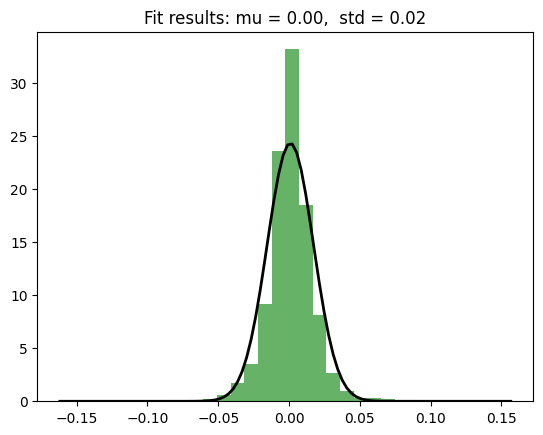

In [31]:
# Assume 'daily_return' is a Series or a single column DataFrame
returns = tickerDf['daily_return'].dropna()  # Remove NaN values for plotting

# Plot histogram
plt.hist(returns, bins=30, density=True, alpha=0.6, color='g')

# Plot the PDF of the normal distribution using returns' mean and standard deviation
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, returns.mean(), returns.std())
plt.plot(x, p, 'k', linewidth=2)

title = "Fit results: mu = %.2f,  std = %.2f" % (returns.mean(), returns.std())
plt.title(title)

plt.show()


In [32]:
transition_matrix = pd.crosstab(tickerDf['state'], tickerDf['state'].shift(-1), normalize='index')

print(transition_matrix)

state      down        up
state                    
down   0.452439  0.547561
up     0.486706  0.513294


In [33]:
# Define the model
n_components = 2  # for example, 'volatile' and 'stable'

# Initialize the HMM
model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000)

# Prepare the data (the observed sequence of daily returns)
returns = tickerDf['daily_return'].dropna().values
returns = returns.reshape(-1, 1)  # hmmlearn expects a 2D array

# Train the HMM
model.fit(returns)

# Predict the hidden states
hidden_states = model.predict(returns)

In [34]:
# Prepare the data (the observed sequence of daily returns)
returns = tickerDf['daily_return'].dropna().values
returns = returns.reshape(-1, 1)  # hmmlearn expects a 2D array

# Predict the hidden states for the entire series
hidden_states = model.predict(returns)

# Infer the direction for each day based on the model's predictions
predicted_directions = []
for i in range(len(hidden_states)-1):  # exclude the last day since there's no next day to predict
    current_state = hidden_states[i]
    next_state_probs = model.transmat_[current_state]
    next_state = np.argmax(next_state_probs)
    predicted_mean_return = model.means_[next_state][0]
    predicted_directions.append('up' if predicted_mean_return > 0 else 'down')

# Append the last day's prediction
# This prediction assumes the same state as the last known state since there's no future data
predicted_directions.append('up' if model.means_[hidden_states[-1]][0] > 0 else 'down')

# Insert the predicted directions into the DataFrame
tickerDf['predicted_direction'] = ['up'] + predicted_directions  # add 'up' as a placeholder for the first day

# Now, calculate the accuracy
tickerDf['actual_next_day_direction'] = np.where(tickerDf['daily_return'].shift(-1) >= 0, 'up', 'down')
tickerDf = tickerDf[:-1]  # Remove the last row as there's no actual next day to compare

# Calculate the accuracy
accuracy = np.mean(tickerDf['predicted_direction'] == tickerDf['actual_next_day_direction'])
print(f"Prediction accuracy: {accuracy:.2%}")

# Print the DataFrame to see the actual vs predicted
print(tickerDf[['Date', 'daily_return', 'actual_next_day_direction', 'predicted_direction']])


Prediction accuracy: 53.60%
            Date  daily_return actual_next_day_direction predicted_direction
0     2010-01-04           NaN                        up                  up
1     2010-01-05      0.000323                      down                  up
2     2010-01-06     -0.006137                      down                  up
3     2010-01-07     -0.010400                        up                  up
4     2010-01-08      0.006897                      down                  up
...          ...           ...                       ...                 ...
3478  2023-10-27      0.005856                        up                  up
3479  2023-10-30      0.022740                        up                  up
3480  2023-10-31      0.002372                        up                  up
3481  2023-11-01      0.023543                        up                  up
3482  2023-11-02      0.006502                        up                  up

[3483 rows x 4 columns]


Prediction

In [35]:
class HiddenMarkovModelPredictor:
    def __init__(self, n_components, n_iter=1000):
        self.model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=n_iter)

    def fit(self, data):
        dropna_data =  data[~np.isnan(data)]
        reshaped_data = dropna_data.reshape(-1, 1)
        self.model.fit(reshaped_data)

    def predict(self, data):
        reshaped_data = data.reshape(-1, 1)
        return self.model.predict(reshaped_data)
    
    def predict_next_hidden_state(self, last_data_point):
        reshaped_data = last_data_point.reshape(1, -1)
        _, next_hidden_state = self.model.decode(reshaped_data)
        return next_hidden_state[-1]  # Return the last state in the sequence

    def predict_next_price(self, last_price, last_pct_chg):
        next_hidden_state = self.predict_next_hidden_state(last_pct_chg)
        next_pct_chg = self.model.means_[next_hidden_state]
        next_price = last_price * (1 + next_pct_chg)
        return next_price
    
    def predict_next_state_probs(self, last_observed_data):
        reshaped_data = last_observed_data.reshape(-1, 1)
        _, current_state = self.model.decode(reshaped_data)
        next_state_probs = self.model.transmat_[current_state[-1], :]
        return next_state_probs
    
    
    def predict_direction(self, last_data_point):
        next_hidden_state = self.predict_next_hidden_state(last_data_point)
        predicted_mean_return = self.model.means_[next_hidden_state][0]
        direction = 'up' if predicted_mean_return > 0 else 'down'
        return direction


In [36]:
# Initialize the HMM predictor
hmm_predictor = HiddenMarkovModelPredictor(n_components=2)
hmm_predictor.fit(tickerDf['daily_return'].dropna().values)

# Assume you want to predict the next state given the last data point
last_data_point = tickerDf['daily_return'].iloc[-1]
next_state_probs = hmm_predictor.predict_next_state_probs(np.array([last_data_point]))

# Predict the next price given the last price and the last percentage change
last_price = tickerDf['Close'].iloc[-1]
predicted_next_price = hmm_predictor.predict_next_price(last_price, last_data_point)

print(f"The predicted next price is: {predicted_next_price}")

# Assuming you have the last observed daily return and the last observed price
last_pct_chg = tickerDf['daily_return'].iloc[-1]
last_price = tickerDf['Close'].iloc[-1]

# Initialize the HMM predictor
hmm_predictor = HiddenMarkovModelPredictor(n_components=2)
hmm_predictor.fit(tickerDf['daily_return'].dropna().values)

# Predict the direction
predicted_direction = hmm_predictor.predict_direction(last_pct_chg)

print(f"The model predicts a {predicted_direction} day for the next trading session.")


The predicted next price is: [348.72796368]
The model predicts a up day for the next trading session.
